# COGS 118A - Final Project

# The Price of Beer

## Group members
- Dhathry Doppalapudi | A16298078
- Serina Khanna | A15851279
- Niko Calsada | A15352545

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

Since COVID-19 began to spread in March 2020, supply chain issues for various products have increased and many industries have been affected. Among restaurants, there was a significant labor shortage and home delivery systems became more popular <a name="forbes"></a>[<sup>[5]</sup>](#forbes). While these new options are definitely more popular among consumers, a lack of in-person customers have affected establishments that rely on people buying their products in-person, such as establishments that sell alcohol. In addition, the war in Ukraine and inflation have impacted the alcohol industry, with 20% of the world’s barley coming from Ukraine and beer prices rising slightly<a name="war"></a>[<sup>[1]</sup>](#war). In addition, given that our data is from a Russian bar, it’s possible that our data has been impacted by the Russian-Ukrainian war as many people boycotted Russian alcohol<a name="mccormick"></a>[<sup>[2]</sup>](#mccormick).

We’re interested in training a machine learning model to predict craft beer prices based on data directly from a bar located in Russia. There have been studies on beer prices<a name="beeralytics"></a>[<sup>[3]</sup>](#beeralytics), but none that have attempted to predict beer prices themselves. There have also been models trained on predicting beer quality<a name="jeevan"></a>[<sup>[4]</sup>](#jeevan)., which predicts the quality of a beer using ratings from the Tastings website, alcohol content, kind of alcohol, price, country of origin, and style/flavor. While many of these quantities overlap with our project, we won’t be training our model on opinion-based data.

Our trained model can be important for Russian bars to learn how to price their beers, or for brands to be able to predict a good price for a new beer.


# Problem Statement

In our project, we aim to solve the problem of predicting the future prices of different types of craft beer in Russia. The majority of variables we will analyze in this project, such as ABV (percentage), volume (mL), number of units sold, and discounted prices are quantitative metrics, which will allow us to predict the future price (in Russian rubles) mathematically. We are implementing multiple linear regression to predict the beer prices based on the multiple independent variables we have in our data. After this, our model can be used by beer manufacturers to determine the reasonable price to set their beer or by bars to determine when to purchase beer.

# Data

Dataset 1: https://www.kaggle.com/datasets/podsyp/sales-in-craft-beer-bar?select=Product_range.csv

Dataset 2: https://www.kaggle.com/datasets/podsyp/sales-in-craft-beer-bar?select=Transactions.csv

Our dataset contains information regarding Nelson Sauvin Bar sales history. Nelson Sauvin Bar is a Russian establishment founded in the spring of 2016. Their inventory contains a wide variety of domestic Russian beers and imported beers from other European countries and the USA. We have obtained two different data sets regarding Nelson Sauvin’s product range and their transaction history. In this project, we will specifically be looking at their transaction history from January 2020 to September 2022.

The first dataset regarding product range contains 5314 observations listed as product codes. For each code, there are 8 associated variables describing the following features: product code, country of origin, vendor code, name of product, ABU, size, retail price, and base unit. The critical variables we focus on are product code, ABU (%), retail price (rubles), and size (L).

The second dataset, our transaction history dataset contains 50084 observations which represent the date and times of register unloadings. Each unloading has the following 7 features: product code, amount of units sold, sale amounts, discount amount, profit, discount percentage, and percentage markup. The variables we focus on are product code, amount (rubles), and sale amount (rubles).

We clean both datasets individually by removing unimportant variables and any rows with null values. We also convert any values needed to be floats and reset the index. We then merge both datasets together based on product code. 

Additionally, since our project is only concerned with this bar in Russia, there is no conversion of any currency over to the USD. All values of currency will remain in rubles.



In [26]:
# import packages and get data
import numpy as np
import pandas as pd
import sklearn #if this doesn't work, run in terminal: $pip3 install -U scikit-learn scipy matplotlib 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

product_range = pd.read_csv('data/Product_range.csv')
transactions = pd.read_csv('data/Transactions.csv')
product_range.head()

,Product_code,Vendor_code,Name,Retail_price,Base_unit,Country_of_Origin,Size,ABV
0,5028,NaN,1 Symbiotica Apple 0.375,300.0,Pieces,Russia,0.375,4.5
1,4846,NaN,1 Symbiotica Hard Kombucha Renegade Aronia 0.33,200.0,Pieces,Russia,0.330,3.0
2,1340,NaN,1000 IBU Imperial IPA Barrel l,960.0,Liters,NaN,1.000,9.6
3,4372,NaN,18th Street Brewery,NaN,NaN,USA,NaN,NaN
4,4302,NaN,18th Street Brewery Deal With The Devil 0.473,630.0,Pieces,USA,0.473,8.5


In [27]:
# Data Filtering - Product_Range
product_range = product_range.drop(columns=['Base_unit'])#,'Country_of_Origin'

# Standardizing columns
product_range['Name'] = product_range['Name'].str.replace('\d+','', regex=True).str.strip('.')

product_range.columns = ['Product_code', 'Vendor', 'Name', 'Price','Country', 'Size', 'ABV']

product_range['Product_code'] = pd.to_numeric(product_range['Product_code'])
product_range['Price'] = pd.to_numeric(product_range['Price'])
product_range['Size'] = pd.to_numeric(product_range['Size'])
product_range['ABV'] = pd.to_numeric(product_range['ABV'])

# Removing missing/NaN
product_range = product_range.dropna()
product_range = product_range.reset_index(drop=True)

# Reducing number of categorical Country variables for 
product_range['Country'] = product_range['Country'].replace(['Denmark', 'United Kingdom', 'Estonia', 'Spain', 'Germany', 'Norway', 'Italy', 'France', '???', 'Ireland', 
                                  'Canada', 'Finland', 'Scotland', 'Japan', 'Latvia', 'Czech', 'Croatia', 'Austria', 'Switzerland', 
                                  'China', 'Brazil', 'Israel'], 'Other')

product_range = pd.get_dummies(product_range, columns = ['Country'])

product_range.head()

,Product_code,Vendor,Name,Price,Size,ABV,Country_Belgium,Country_Netherlands,Country_Other,Country_Russia,Country_Sweden,Country_USA
0,170,3Fonteine,Fonteinen Doesjel / lambic / % /,850.0,0.375,6.0,1,0,0,0,0,0
1,1176,3Fonteine,Fonteinen Intense Red Oude Kriek / % /,3300.0,0.750,6.0,1,0,0,0,0,0
2,726,3Fonteine,Fonteinen Oude Geuze / % /,1500.0,0.750,6.0,1,0,0,0,0,0
3,1617,3Fonteine,Fonteinen Oude Geuze / % /,950.0,0.375,5.0,1,0,0,0,0,0
4,4548,3Fonteine,Fonteinen Oude Geuze Assemblage,1100.0,0.375,6.6,1,0,0,0,0,0


In [28]:
# Data Filtering - Transactions

# First, we filtered the date and time column to only include the date of our transactions. Our observations are sorted in increasing date order. 
# For this project we are only focusing on the sale amount of a given transaction. This means we are not concerned with the data regarding discount amount, percentage markup, discount percentage, and profit.

from datetime import datetime,date

transactions['Date_and_time_of_unloading'] = pd.to_datetime(transactions['Date_and_time_of_unloading'])
transactions['Date'] = transactions['Date_and_time_of_unloading'].dt.date
transactions = transactions.drop(columns=['Date_and_time_of_unloading'])#,'Discount_amount', 'Percentage_markup', 'Discount_percentage', 'Profit'
transactions = transactions.dropna().reset_index(drop=True)

transactions.head()

,Product_code,Amount,Sale_amount,Discount_amount,Profit,Percentage_markup,Discount_percentage,Date
0,209,2.0,545.73,294.27,75.73,16.11,35.03,2020-01-01
1,213,2.0,1265.05,34.95,653.05,106.71,2.69,2020-01-01
2,217,1.0,630.00,70.00,220.50,53.85,10.00,2020-01-01
3,222,2.0,1104.75,195.25,393.75,55.38,15.02,2020-01-01
4,243,1.0,292.36,157.64,1.36,0.47,35.03,2020-01-01


In [29]:
# Check new shape/total remaining data of both
print("Product range shape:" + str(product_range.shape))
print("Transaction shape: " + str(transactions.shape))

Product range shape:(3838, 12)
Transaction shape: (38297, 8)


/var/folders/1h/p0yg3zrn74952165spggmcxr0000gn/T/ipykernel_20476/1444340026.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(product_range.corr(),linewidths=0.1, annot=True,cmap='YlGn') #[['Price', 'Size', 'ABV']]


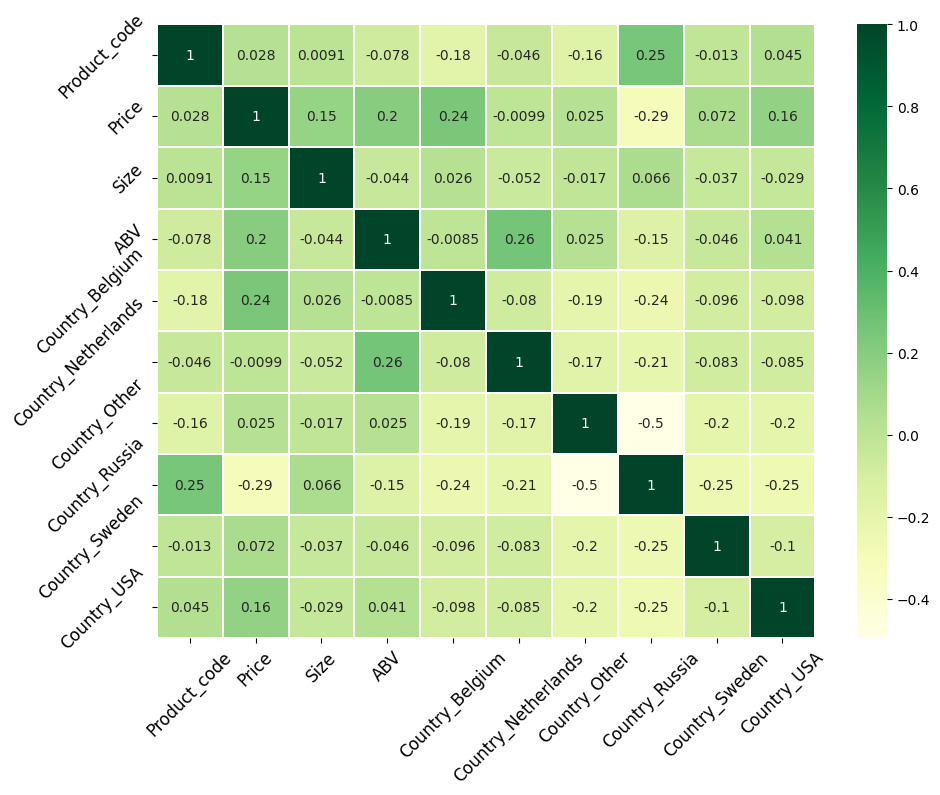

In [30]:
# We can link together the datasets by the product_code in both but that might be messyyyy but we might have to at some point
# Plot relationship between all variables of product_range
plt.figure(figsize=(10, 8))
sns.heatmap(product_range.corr(),linewidths=0.1, annot=True,cmap='YlGn') #[['Price', 'Size', 'ABV']]
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12, rotation=45) 
plt.show()

/var/folders/1h/p0yg3zrn74952165spggmcxr0000gn/T/ipykernel_20476/1631982020.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(transactions.corr(),linewidths=0.1, annot=True,cmap='YlGn')


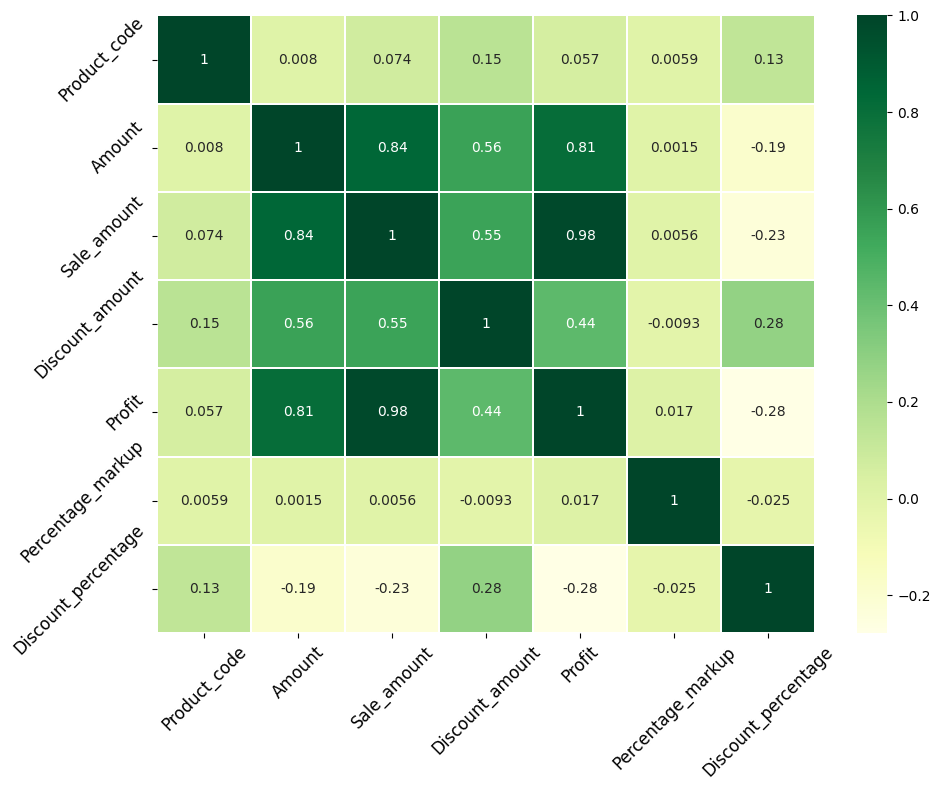

In [31]:
# Plot relationship between all variables of transactions
plt.figure(figsize=(10, 8))
sns.heatmap(transactions.corr(),linewidths=0.1, annot=True,cmap='YlGn')
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12, rotation=45) 
plt.show()

In [34]:
# Merge the two datasets
df = product_range.merge(transactions, on= 'Product_code')
print("Merged shape: " + str(df.shape))

Merged shape: (29917, 19)


Text(0, 0.5, 'Predicted')

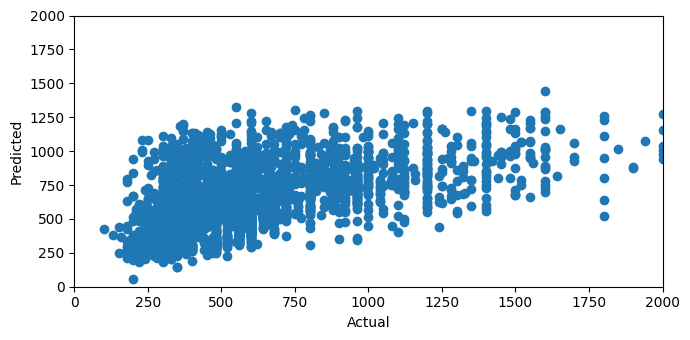

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

split = int(product_range.shape[0]*0.8)

X = product_range[['Product_code', 'Size', 'ABV', 'Country_Belgium', 'Country_Netherlands', 'Country_Other', 'Country_Russia', 
                   'Country_Sweden', 'Country_USA']]
Y = product_range['Price']

X_train, X_test, y_train, y_true = train_test_split(X, Y, test_size = 0.8, random_state = 0)

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.scatter(y_true ,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

Text(0, 0.5, 'Predicted')

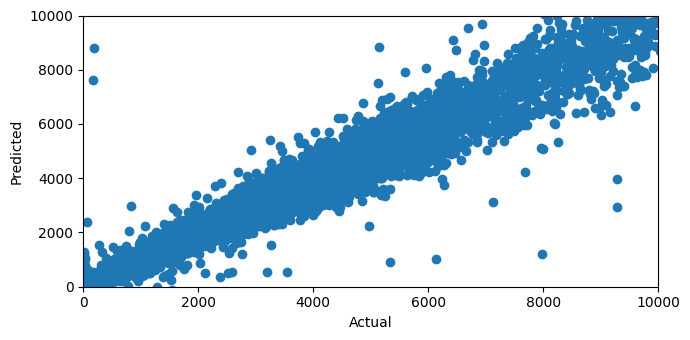

In [36]:
split2 = int(transactions.shape[0]*0.8)

X2 = transactions[['Product_code', 'Amount', 'Discount_amount', 'Profit', 'Percentage_markup', 'Discount_percentage']]#[['Product_code','Amount']] #, 'Profit'
Y2 = transactions['Sale_amount']

X2_train, X2_test, y2_train, y2_true = train_test_split(X2, Y2, test_size = 0.8, random_state = 0)

LR_model2 = LinearRegression()
LR_model2.fit(X2_train, y2_train)
y2_pred = LR_model2.predict(X2_test)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.scatter(y2_true ,y2_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [37]:
X3 = df[['Product_code', 'Size', 'ABV', 'Amount', 'Discount_amount', 'Profit', 'Percentage_markup', 'Discount_percentage', "Sale_amount"]] #, 'Profit'
Y3 = df['Price']

X3_train, X3_test, y3_train, y3_true = train_test_split(X3, Y3, test_size = 0.8, random_state = 0)

LR_model3 = LinearRegression()
LR_model3.fit(X3_train, y3_train)
y3_pred = LR_model3.predict(X3_test)

Text(0, 0.5, 'Predicted')

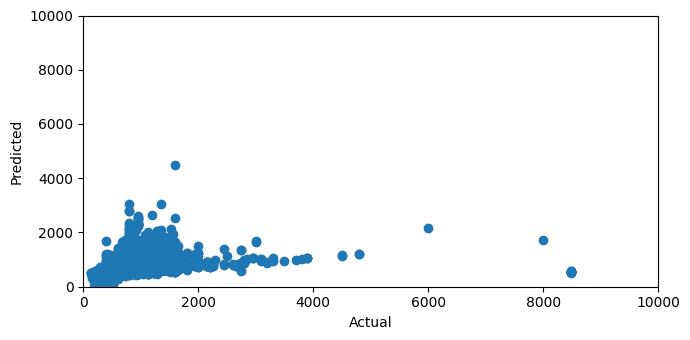

In [38]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.scatter(y3_true ,y3_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Proposed Solution

Because this is a regression problem, we are going to attempt to use multiple linear regression to train our model. Multiple linear regression allows us to predict continuous values (like the price of beer) when considering multiple independent variables (manufacturer, SKU, country of origin, SKU size, and alcohol by volume). Other models that could work include regular Linear Regression, polynomial regression for a polynomial relationship, or decision tree regression (which would be better suited with less independent variables).

The libraries we will use are numpy, sklearn, and pandas.
- Clean data of missing values, NaN, and variables that we won’t be considering
- Check correlation of data via multiple scatter plots
- Split data into test/train set
- Formulate Multiple Linear Regression model
- Fit model to train data, test model on testing data
- Use Ordinary Least Squares to minimize the residual

If we see that the relationship between any of the independent variables and the price is different than expected, or if any assumptions surrounding linear regression are broken, we will consider changing our model to another one. To make our results more accurate, we will also experiment with different kinds of regularization (OLS, L1, L2, Lasso) and different regularization strengths.


# Evaluation Metrics

We are using the Mean Squared Error (MSE) to find the average difference between the actual and predicted values for craft beer prices, as it is the standard with Ordinary Least Squares.

The equation for Mean Squared Error is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/ae01f23f2ed2814c7db94e1fdc952732f5ca533a)

where given a vector of $n$ observations from a sample taken from $n$ data points on all independent variables, with $Y$ being the observed values being predicted and $\hat{Y}$ being the predicted values.


# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Maybe you include a learning curve to show whether you have enough data to do train/validate/test split or have to go to k-folds or LOOCV or ???

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?



# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

If your project has obvious potential concerns with ethics or data privacy discuss that here.  Almost every ML project put into production can have ethical implications if you use your imagination. Use your imagination.

Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="war"></a>1.[^](#war): “War in Ukraine Could Impact Beer Prices in US.” ABC7 Chicago, 27 Feb. 2022, https://abc7chicago.com/russia-ukraine-war-cost-of-beer-prices-craft/11603203/. <br> 
<a name="mccormick"></a>2.[^](#mccormick): McCormick, Tom, and Posted by Tom McCormick. “War in Ukraine Has Far Reaching Impact on Alcohol Beverage Industry.” ProBrewer, 1 Mar. 2022, https://www.probrewer.com/beverage-industry-news/international/war-in-ukraine-has-far-reaching-impact-on-alcohol-beverage-industry/. <br>
<a name="beeralytics"></a>3.[^](#beeralytics): “Beeralytics — A Guide to Analyzing Beer Prices from Web Data.” Towards Data Science, 23 March, 2020, https://towardsdatascience.com/beeralytics-a-guide-to-analyzing-beer-prices-from-web-data-37d4ba206071.<br>
<a name="jeevan"></a>4.[^](#jeevan): “[Project] Predicting Alcohol Quality Using Machine Learning - Part I.” UpLevel, 28 July 2020, https://projects.uplevel.work/features/predicting-alcohol-quality-using-machine-learning. <br>
<a name="forbes"></a>5.[^](#forbes): “Trends Affecting The Restaurant Industry In 2022” Forbes, 16 March 2022, https://www.forbes.com/sites/garyocchiogrosso/2022/03/16/trends-affecting-the-restaurant-industry-in-2022/ . <br>